In [2]:
import devsim
import numpy
import matplotlib

In [3]:
import devsim.python_packages

In [4]:
from devsim import *
devsim.reset_devsim()

Resetting DEVSIM


In [5]:
devsim.set_parameter(name="debug_level",value = "info")
print(devsim.get_parameter(name="debug_level"))

info


In [6]:
#1D Capacitor
devsim.create_1d_mesh(mesh="cap_mesh")
devsim.add_1d_mesh_line(mesh="cap_mesh", pos=0.0, ps=0.1, tag="top") #top plate of capacitor
devsim.add_1d_mesh_line(mesh="cap_mesh", pos=1.0, ps=0.1, tag="bottom") #bottom plate of capacitor
#these lines add points to the cap_mesh, cap_mesh is the entire capacitor while top, bottom are the two points

In [7]:
#Now we create regions within the capacitor
devsim.add_1d_region(mesh="cap_mesh", material="Si", region="cap_region",tag1="top", tag2="bottom")

In [8]:
#Now we have to define the contacts (terminals) at both ends
devsim.add_1d_contact(mesh="cap_mesh", name="top_contact", tag="top", material="metal")
devsim.add_1d_contact(mesh="cap_mesh", name="bottom_contact", tag="bottom", material="metal")
#material of contact is not semiconductor, it is metal

devsim.finalize_mesh(mesh="cap_mesh")

bottom
 (region: cap_region)
 (contact: top_contact)
 (contact: bottom_contact)


In [9]:
#convert the mesh to a devsim device. before this the mesh has to be finalised
devsim.create_device(mesh="cap_mesh", device="cap_device")
print("Capacitor created successfully")

Capacitor created successfully


In [10]:
#Defining the electric potential
devsim.node_model(
    device = "cap_device",
    region = "cap_region",
    name = "Potential",
    equation = "V"
)
#devsim creates variables for each 'node' i.e. 'point'. stores potential at each of these points. later when we will add equations, we will modify these
#variables accordingly

'V'

In [11]:
#Now we will plug in properties of the material like permittivity
devsim.set_parameter(device="cap_device", region="cap_region", name="Permittivity", value = 3.9*8.85e-14) #value for SiO2

In [12]:
#Now we want to actually solve the Poisson equations to obtain the correct voltages
#First create solution variable

node_solution(device = "cap_device", region="cap_region", name = "Potential")

Replacing Node Model Potential in region cap_region of material Si


In [13]:
#We have nodes and edges
#Node model- used for calculating values at ONE point
#Edge model- used for calculating difference

In [14]:
edge_from_node_model(device= "cap_device", region = "cap_region", node_model= "Potential")

In [15]:
#The above line creates an edge model from the potentials, i.e. creates Potential@n0 and Potential@n1 as edge model

In [16]:
#Compute Electric Field
edge_model(device= "cap_device", region = "cap_region", name="ElectricField",
equation="(Potential@n0 - Potential@n1)*EdgeInverseLength")

#E = deltaV/d

'((Potential@n0 - Potential@n1) * EdgeInverseLength)'

In [17]:
#Now computing the derivatives of the electric field
edge_model(device= "cap_device", region = "cap_region", name="ElectricField:Potential@n0", #this kind of name defines partial derivatives
equation="EdgeInverseLength")

edge_model(device= "cap_device", region = "cap_region", name="ElectricField:Potential@n1",
equation="-EdgeInverseLength")

'(-EdgeInverseLength)'

In [18]:
#Create displacement field
edge_model(device= "cap_device", region = "cap_region", name = "DField", equation = "Permittivity*ElectricField")

'(Permittivity * ElectricField)'

In [19]:
#Compute derivatives of D_field
edge_model(device = "cap_device", region = "cap_region", name = "DField:Potential@n0", equation = "diff(Permittivity*ElectricField, Potential@n0)")
edge_model(device = "cap_device", region = "cap_region", name = "DField:Potential@n1", equation = "-DField:Potential@n0")

'(-DField:Potential@n0)'

In [20]:
device = "cap_device"
region = "cap_region"

#Defining the bulk equation, in case Poisson equation
equation(device=device, region=region, name="PotentialEquation",
variable_name="Potential", edge_model="DField",
variable_update="default")

In [21]:
#Defining contact boundary conditions
for c in ("top_contact", "bottom_contact"):
    contact_node_model(device=device, contact=c, name="%s_bc" % c, equation="Potential - %s_bias" % c)
    

    contact_node_model(device=device, contact=c, name="%s_bc:Potential" % c,equation="1")
    
    
    contact_equation(device=device, contact=c, name="PotentialEquation", node_model="%s_bc" % c, edge_charge_model="DField")
    

In [22]:
#Setting boundary conditions at the contacts
set_parameter(device=device, region=region, name="bottom_contact_bias", value=1.0e-0)
set_parameter(device=device, region=region, name="top_contact_bias", value=0.0)

In [23]:
#Solve the system
solve(type="dc", absolute_error=1.0, relative_error=1e-10, maximum_iterations=30)

number of equations 11
Iteration: 0
  Device: "cap_device"	RelError: 1.00000e+00	AbsError: 1.00000e+00
    Region: "cap_region"	RelError: 1.00000e+00	AbsError: 1.00000e+00
      Equation: "PotentialEquation"	RelError: 1.00000e+00	AbsError: 1.00000e+00
Iteration: 1
  Device: "cap_device"	RelError: 2.63296e-16	AbsError: 1.14095e-16
    Region: "cap_region"	RelError: 2.63296e-16	AbsError: 1.14095e-16
      Equation: "PotentialEquation"	RelError: 2.63296e-16	AbsError: 1.14095e-16


In [24]:
#Now let us print the charges on the contacts
for c in ("top_contact", "bottom_contact"):
    print("contact: %s charge: %1.5e" % (c, get_contact_charge(device = device, contact = c, equation = "PotentialEquation")))

contact: top_contact charge: -3.45150e-13
contact: bottom_contact charge: 3.45150e-13


In [25]:
import matplotlib.pyplot as plt

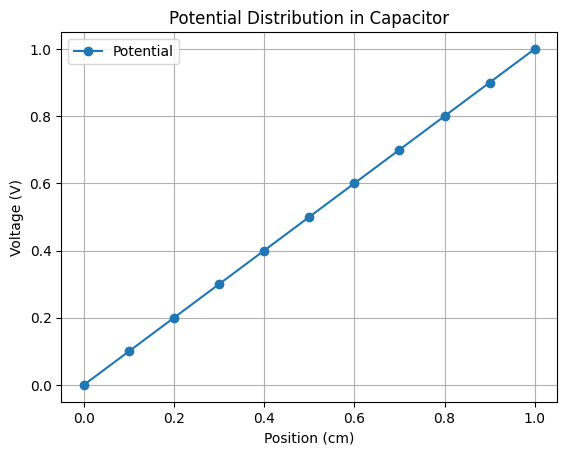

In [26]:
#Potential vs position
# Get node positions
node_positions = devsim.get_node_model_values(device="cap_device", region="cap_region", name="x")

# Get potential values
potential_values = devsim.get_node_model_values(device="cap_device", region="cap_region", name="Potential")

# Plot Potential vs. Position
plt.plot(node_positions, potential_values, marker="o", linestyle="-", label="Potential")
plt.xlabel("Position (cm)")
plt.ylabel("Voltage (V)")
plt.title("Potential Distribution in Capacitor")
plt.legend()
plt.grid(True)
plt.show()

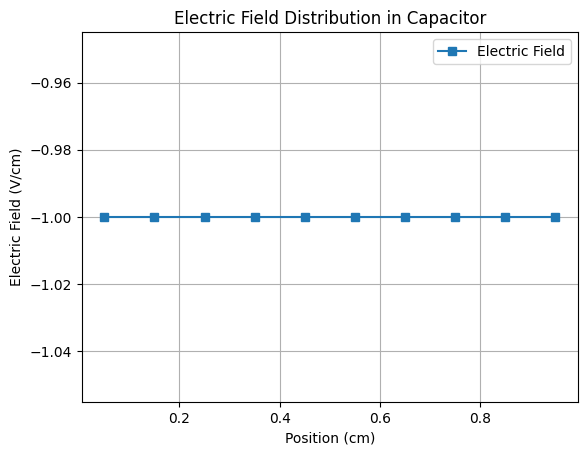

In [27]:
#Electric field vs position
# Get Electric Field values
electric_field = devsim.get_edge_model_values(device="cap_device", region="cap_region", name="ElectricField")

# Get edge positions (midpoints between nodes)
edge_positions = [(node_positions[i] + node_positions[i+1]) / 2 for i in range(len(node_positions)-1)]

# Plot Electric Field vs. Position
plt.plot(edge_positions, electric_field, marker="s", linestyle="-", label="Electric Field")
plt.xlabel("Position (cm)")
plt.ylabel("Electric Field (V/cm)")
plt.title("Electric Field Distribution in Capacitor")
plt.legend()
plt.grid(True)
plt.show()